# RAG on local device

1. Document preprocessing and embedding creation
2. Search and Answer

### 1. Document/text processing and embedding creation

In [1]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading...")
    
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    
    filename = pdf_path
    
    response = requests.get(url)
    
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")
        
else:
    print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


In [2]:
import fitz

from tqdm.auto import tqdm

def text_formatter(text:str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()
    
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number":page_number-41,
                                "page_char_count":len(text),
                                "page_word_count":len(text.split(" ")),
                                "page_sentence_count_raw" : len(text.split(". ")),
                                "page_token_count":len(text) / 4,
                                "text":text})
        
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [3]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 1126,
  'page_char_count': 1410,
  'page_word_count': 215,
  'page_sentence_count_raw': 21,
  'page_token_count': 352.5,
  'text': 'lifetime.4 Treatment often involves antidepressant medication as  well as nutritional and psychiatric counseling.  Orthorexia Nervosa  Orthorexia nervosa was coined in 1997 by physician Steven  Bratman.5 The term uses “ortho,” in its meaning as straight, correct  and true and refers to a fixation on eating proper food.6 Fixation  on ‘healthy eating’ by those with orthorexia nervosa often results in  behaviors that end up damaging one’s well-being such as extreme  weight loss or a refusal to dine out with friends. Orthorexia nervosa  like anorexia nervosa involves restriction of the amount and variety  of foods eaten, however those with orthorexia nervosa do not have  4. Eating Disorders. The National Institute of Mental  Health. https://www.nimh.nih.gov/health/statistics/ eating-disorders.shtml#part_155061. Accessed April 15,  2018.  5. Ma

In [4]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
df.describe().round(decimals=2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


#### Further text processing (splitting pages into sentences)

In [6]:
from spacy.lang.en import English

nlp = English()

# Add Sentencizer pipeline
nlp.add_pipe("sentencizer")

# Document instance example
doc = nlp("This is a sentence. This is another one. This is the last.")
assert len(list(doc.sents)) == 3

# Sentences split
list(doc.sents)

[This is a sentence., This is another one., This is the last.]

In [7]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 863,
 'page_word_count': 138,
 'page_sentence_count_raw': 9,
 'page_token_count': 215.75,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5. Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.   https://ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitamins  | 

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # spaCy datatype to str
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': 1004,
  'page_char_count': 1375,
  'page_word_count': 250,
  'page_sentence_count_raw': 15,
  'page_token_count': 343.75,
  'text': 'Moldy  nectarines by  Roger  McLassus  1951 / CC  BY-SA 3.0  Warm, humid, or damp conditions encourage mold to grow on food.  Molds are microscopic fungi that live on animals and plants. No  one knows how many species of fungi exist, but estimates range  from ten- to three-hundred thousand. Unlike single-celled bacteria,  molds are multicellular, and under a microscope look like slender  mushrooms. They have stalks with spores that form at the ends. The  spores give molds their color and can be transported by air, water,  or insects. Spores also enable mold to reproduce. Additionally,  molds have root-like threads that may grow deep into food and  be difficult to see. The threads are very deep when a food shows  heavy mold growth. Foods that contain mold may also have bacteria  growing alongside it.  Some molds, like the kind found in blu

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


In [11]:
# Chunking sentences into smaller groups

num_sentence_chunk_size = 10

# split lists of texts recursively into chunk size
def split_list(input_list: list[str],
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    
    item["num_chunks"] = len(item["sentence_chunks"])
    
    

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': 194,
  'page_char_count': 98,
  'page_word_count': 15,
  'page_sentence_count_raw': 1,
  'page_token_count': 24.5,
  'text': 'view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=153    194  |  Chloride',
  'sentences': ['view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=153    194  |  Chloride'],
  'page_sentence_count_spacy': 1,
  'sentence_chunks': [['view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=153    194  |  Chloride']],
  'num_chunks': 1}]

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


In [15]:
#random.sample(pages_and_texts, k=1)
import re

pages_and_chunks = []

# Split each chunk into its own item
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join sentences together into a paragraph-like structure (join the list of sentences into one paragraph)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        # joined_sentence_chunk = 
        
        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        
        # Check stats about chunks
        chunk_dict["chunk_char_count"]  = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")]) # Crude word count
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars
        
        pages_and_chunks.append(chunk_dict)
        
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [16]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 436,
  'sentence_chunk': 'Image by Serge Esteve on unsplash.co m / CC0 Alcohol Metabolism UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM Giving the liver enough time to fully metabolize the ingested alcohol is the only effective way to avoid alcohol toxicity. Drinking coffee or taking a shower will not help. The legal limit for intoxication is a BAC of 0.08. Taking into account the rate at which the liver metabolizes alcohol after drinking stops, and the alcohol excretion rate, it takes at least five hours for a legally intoxicated person to achieve sobriety. Figure 7.1 Alcohol Metabolism Summary 436 | Alcohol Metabolism',
  'chunk_char_count': 655,
  'chunk_word_count': 107,
  'chunk_token_count': 163.75}]

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


#### Filter chunks of text for short chunks

In [18]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"]<= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 24.25 | Text: There are several lecithin supplements on the market Nonessential and Essential Fatty Acids | 315
Chunk token count: 28.25 | Text: A concentration gradient is a form of potential energy, like water 172 | Electrolytes Important for Fluid Balance
Chunk token count: 11.75 | Text: Accessed April 15, 2018. 1046 | Comparing Diets
Chunk token count: 6.5 | Text: Fat-Soluble Vitamins | 539
Chunk token count: 5.5 | Text: 1050 | Comparing Diets


In [19]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [20]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 946,
  'sentence_chunk': 'workout four to five days per week, you can become more active in simple ways—by taking the stairs instead of the elevator, by walking more instead of driving, by going out dancing with your friends, or by doing your household chores at a faster pace. It is not necessary to perform at the level of a professional dancer or athlete, or to work out for several hours every day, to see real gains from exercise. Even slightly increased activity can lead to physical benefits, such as: • Longer life. A regular exercise program can reduce your risk of dying early from heart disease, certain cancers, and other leading causes of death. • Healthier weight. Exercise, along with a healthy, balanced eating plan, can help you lose extra weight, maintain weight loss, or prevent excessive weight gain. • Cardiovascular disease prevention. Being active boosts HDL cholesterol and decreases unhealthy triglycerides, which reduces the risk of cardiovascular diseases.

#### Embedding text chunks

In [21]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")

# Create list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings.",
"Sentences can be embedded one by one or in a list.",
"I like horses!"]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# Check embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

Sentence: The Sentence Transformer library provides an easy way to create embeddings.
Embedding: [-3.44286375e-02  2.95328815e-02 -2.33643427e-02  5.57257496e-02
 -2.19098609e-02 -6.47062203e-03  1.02848457e-02 -6.57803863e-02
  2.29717735e-02 -2.61121057e-02  3.80420350e-02  5.61403222e-02
 -3.68746594e-02  1.52787790e-02  4.37020473e-02 -5.19723371e-02
  4.89479862e-02  3.58104147e-03 -1.29751097e-02  3.54387122e-03
  4.23262641e-02  3.52606587e-02  2.49402281e-02  2.99177002e-02
 -1.99382380e-02 -2.39752773e-02 -3.33367917e-03 -4.30450514e-02
  5.72014526e-02 -1.32517833e-02 -3.54477987e-02 -1.13935936e-02
  5.55561110e-02  3.61099187e-03  8.88527040e-07  1.14027122e-02
 -3.82229425e-02 -2.43548071e-03  1.51314372e-02 -1.32699206e-04
  5.00659943e-02 -5.50876483e-02  1.73444841e-02  5.00959158e-02
 -3.75959277e-02 -1.04463594e-02  5.08322380e-02  1.24861132e-02
  8.67377296e-02  4.64143082e-02 -2.10690107e-02 -3.90251614e-02
  1.99698494e-03 -1.42345531e-02 -1.86794791e-02  2.826691

In [22]:
embeddings[0].shape

(768,)

In [23]:
%%time


embedding_model.to("cuda")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 1min 20s, sys: 4.03 s, total: 1min 24s
Wall time: 10.8 s


In [24]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

len(text_chunks)

CPU times: user 1.83 ms, sys: 0 ns, total: 1.83 ms
Wall time: 233 µs


1680

In [25]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True)

CPU times: user 25.6 s, sys: 1.38 s, total: 27 s
Wall time: 3.28 s


In [26]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [27]:
# Import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242601e-02 9.02281553e-02 -5.09549258e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156232e-02 5.92139289e-02 -1.66167468e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801954e-02 3.39814052e-02 -2.06426717e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566836e-02 3.81275043e-02 -8.46853014e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264419e-02 -8.49767029e-03 9.57159698e-...


## 2. RAG - Search and Answer

Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages


In [28]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (as it got converted to string when saved to CSV)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x:np.fromstring(x.strip("[]"), sep=" "))

# Convert embeddings into torch.tensor
embeddings = torch.tensor(np.stack(arrays=text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert texts and embedding tf to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")


text_chunks_and_embeddings_df[:1]

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.0,"[0.0674242601, 0.0902281553, -0.00509549258, -..."


In [29]:
pages_and_chunks[:1]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0,
  'embedding': array([ 6.74242601e-02,  9.02281553e-02, -5.09549258e-03, -3.17545645e-02,
          7.39082173e-02,  3.51976156e-02, -1.97987109e-02,  4.67692763e-02,
          5.35727032e-02,  5.01232594e-03,  3.33929174e-02, -1.62218197e-03,
          1.76080782e-02,  3.62653807e-02, -3.16707330e-04, -1.07118469e-02,
          1.54257929e-02,  2.62176134e-02,  2.77653895e-03,  3.64942439e-02,
         -4.44109589e-02,  1.89361889e-02,  4.90117893e-02,  1.64020080e-02,
         -4.85782959e-02,  3.18291062e-03,  2.72992738e-02, -2.04758975e-03,
         -1.

In [30]:
embeddings.shape

torch.Size([1680, 768])

In [31]:
# Create model

from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

In [32]:
# 1.Define query
query = "macronutrients functions"
print(f"Query: {query}")

# 2.Embed query
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# 3.Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
# : Sentence Transformer result is normalized, therefore here we can use dot product instead of cosine similarity
# : To use dot product for comparision, ensure vector sizes are of same shape (e.g.768) and tensors/vectors are in the same datatype (e.g. both torch.float32)
#   (as well as on same device)
from time import perf_counter as timer

start_time = timer()

dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings:{end_time-start_time:.5f} seconds.")

# 4.Get top-k results (top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
[INFO] Time taken to get scores on 1680 embeddings:0.00048 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [33]:
query_embedding.dtype

torch.float32

In [34]:
embeddings[0].dtype

torch.float32

In [35]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

In [36]:
# vector search example
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [37]:
query = "macronutrient functions"
print(f"Qeury: '{query}'\n")
print("Results:")

# Loop through zipped scores/indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Qeury: 'macronutrient functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are m

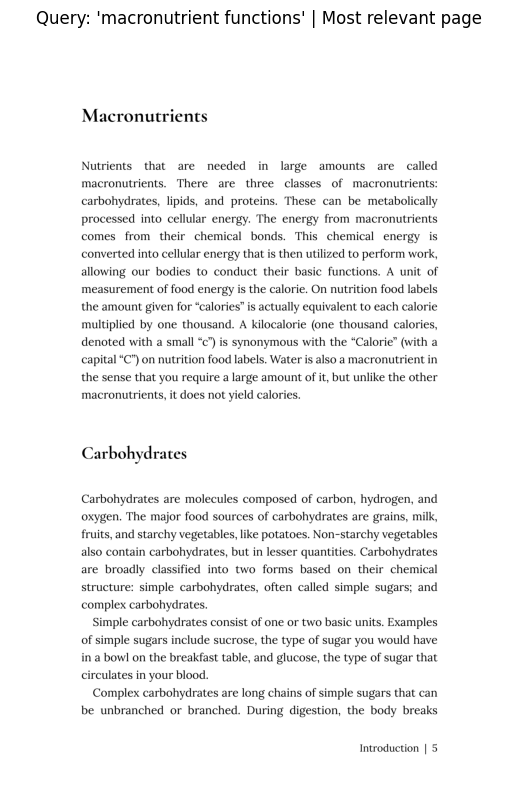

In [38]:
import fitz # pymupdf library
# open PDF and load target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5+41)

# Get image of the page
img = page.get_pixmap(dpi=300)

# Save image (optional)
# img.save("output_filename.png")
doc.close()

# Convert pixmap to numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))
                            # numpy get along well with uint8 values
                            
# img_array

# Display image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page")
plt.axis("off")
plt.show()


#### Similarity measures: dot product and cosine similarity

In [39]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)
    
    # Get Euclidean / L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))
    
    return dot_product / (norm_vector1*norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([1,2,3], dtype=torch.float32)
vector3 = torch.tensor([4,5,6], dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3], dtype=torch.float32)

# Calculate dot product

print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Cosine similarity

print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))


Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


#### Functionizing semantic search pipeline

In [40]:
def retrieve_relevant_resources(query:str,
                                embeddings:torch.tensor,
                                model:SentenceTransformer=embedding_model,
                                n_resources_to_return:int=5,
                                print_time:bool=True):
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)
    
    # Get dot product scores of query embedding and embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()
    
    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
        
    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)
    
    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks:list[dict]=pages_and_chunks,
                                 n_resources_to_return:int=5):
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

    

In [41]:
query="foods high in fiber"
retrieve_relevant_resources(query=query,embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.
[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in th

#### Getting LLM for local generation

In [42]:
# GPU memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Avail GPU mem : {gpu_memory_gb} GB")

Avail GPU mem : 24 GB


In [43]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wed Aug 14 10:52:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:2B:00.0  On |                  Off |
| 30%   44C    P2              62W / 380W |   2283MiB / 24564MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Loading LLM locally

1. Quantization config (optional)
2. Model ID - which model/tokenizer to load
3. Tokenizer - turns text into numbers (different from an embedding model)
4. LLM model - generate text based an input

*flash attention can boost tokenizer (speed up)

In [44]:
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [45]:
# google/gemma-7b-it
model_id = "google/gemma-7b-it"
use_quantization_config = False

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create Quantization config
# requires !pip install bitsandbytes accelerate (huggingface library)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16) # load in 4bit, compute in float16

# flash attention 2 (speeds up Transformer operations)
if (is_flash_attn_2_available) and (torch.cuda.get_device_capability(0)[0]):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product attention
print(f"Using attention impl : {attn_implementation}")
    
# 2. pick a model to use
# model_id = "google/gemma-7b-it"
model_id = model_id

# 3. Instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False,
                                                 attn_implementation=attn_implementation)

if not use_quantization_config:
    llm_model.to("cuda")

    

Using attention impl : flash_attention_2


You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [46]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wed Aug 14 10:53:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:2B:00.0  On |                  Off |
| 30%   43C    P2              62W / 380W |  17680MiB / 24564MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [47]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaFlashAttention2(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gem

In [48]:
def get_model_num_params(model: torch.nn.Module):
    return "{:,}".format(sum(param.numel() for param in model.parameters()))

formatted_params = get_model_num_params(model=llm_model)
print(formatted_params)


8,537,680,896


In [49]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
    
    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)
    
    return {"model_mem_bytes" :model_mem_bytes,
            "model_mem_mb" : round(model_mem_mb,2),
            "model_mem_gb" : round(model_mem_gb,2)}
    
get_model_mem_size(llm_model)

{'model_mem_bytes': 17142470656,
 'model_mem_mb': 16348.33,
 'model_mem_gb': 15.97}


#### Generate text

In [50]:
input_text = "What are the macronutrients, and what roles do they play ihn the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {
        "role":"user",
        "content":input_text
    }
]

# Apply chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
                                       

print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play ihn the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play ihn the human body?<end_of_turn>
<start_of_turn>model



In [51]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-7b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_w

In [52]:
%%time

# Tokenize input text
input_ids = tokenizer(prompt,
                      return_tensors="pt").to("cuda")

# Generate outputs from local LLM
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)


print(f"Model output (tokens):\n{outputs[0]}\n")

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,  19535,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517,    708,    573, 186809, 184592,    578,   1024,
         16065,    575,    573,   3515,   2971, 235292,    109,    688,  12298,
          1695, 184592,  66058,    109,    688, 235274, 235265, 110165,  56227,
         66058,    109, 235290,   5231,  11071,  66058,    108,    139, 235290,
         34428,   4134,    604,    573,   2971, 235265,    108,    139, 235290,
         13332,  41748,   5330,   9347,   5902, 235265,    108,    139, 235290,
         34428,  20149,    604,  51536,    578,  69583,   8069, 235265,    108,
           139, 235290,  13332,   2500, 155248,    604,   7387, 235265,    109,
           688, 235284, 235265,  96084,  66058,    109, 235290,   5231,  11071,
         66058,  

In [53]:
print(outputs.shape)
outputs

torch.Size([1, 190])


tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,  19535,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
          21404, 235269,   1517,    708,    573, 186809, 184592,    578,   1024,
          16065,    575,    573,   3515,   2971, 235292,    109,    688,  12298,
           1695, 184592,  66058,    109,    688, 235274, 235265, 110165,  56227,
          66058,    109, 235290,   5231,  11071,  66058,    108,    139, 235290,
          34428,   4134,    604,    573,   2971, 235265,    108,    139, 235290,
          13332,  41748,   5330,   9347,   5902, 235265,    108,    139, 235290,
          34428,  20149,    604,  51536,    578,  69583,   8069, 235265,    108,
            139, 235290,  13332,   2500, 155248,    604,   7387, 235265,    109,
            688, 235284, 235265,  96084,  66058,    109, 235290,   5231,  11071,
          66058,    108,    

In [54]:
outputs[0]

tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,  19535,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517,    708,    573, 186809, 184592,    578,   1024,
         16065,    575,    573,   3515,   2971, 235292,    109,    688,  12298,
          1695, 184592,  66058,    109,    688, 235274, 235265, 110165,  56227,
         66058,    109, 235290,   5231,  11071,  66058,    108,    139, 235290,
         34428,   4134,    604,    573,   2971, 235265,    108,    139, 235290,
         13332,  41748,   5330,   9347,   5902, 235265,    108,    139, 235290,
         34428,  20149,    604,  51536,    578,  69583,   8069, 235265,    108,
           139, 235290,  13332,   2500, 155248,    604,   7387, 235265,    109,
           688, 235284, 235265,  96084,  66058,    109, 235290,   5231,  11071,
         66058,    108,    139, 235290, 

In [55]:
# Decode output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded) :\n{outputs_decoded}\n")

Model output (decoded) :
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play ihn the human body?<end_of_turn>
<start_of_turn>model
Sure, here are the macronutrients and their roles in the human body:

**Macronutrients:**

**1. Carbohydrates:**

- **Role:**
  - Provide energy for the body.
  - Help regulate blood sugar levels.
  - Provide fiber for digestion and bowel movement.
  - Help build glycogen for storage.

**2. Proteins:**

- **Role:**
  - Build and repair tissues.
  - Make enzymes and other chemicals.
  - Help regulate blood sugar levels.
  - Help build muscle mass and strength.

**3. Fats:**

- **Role:**
  - Provide energy storage.
  - Help absorb vitamins and minerals.
  - Help regulate blood sugar levels.
  - Help build cell membranes.<eos>



In [74]:
# GPT-4 generated nutrition-style questions
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "Water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'Water soluble vitamins']

In [75]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

# Get scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings) 

scores, indices

Query: What are the macronutrients, and what roles do they play in the human body?
[INFO] Time taken to get scores on 1680 embeddings: 0.00004 seconds.


(tensor([0.7302, 0.7233, 0.6962, 0.6942, 0.6416], device='cuda:0'),
 tensor([42, 47, 46, 41, 52], device='cuda:0'))

#### Augmenting prompt with context items

1. Retrieval : Implemented
2. Generation : Implemented
3. Augmentation - prompt engineering
   (1) Give clear instructions
   (2) Give few examples of input/output
   (3) Give room to think (e.g. create a scratchpad/"show your working space"/"let's think step by step...")

In [76]:
pages_and_chunks[420]

{'page_number': 277,
 'sentence_chunk': 'Due to the potential health consequences of consuming too many added sugars, sugar substitutes have replaced them in many foods and beverages. Sugar substitutes may be from natural sources or artificially made. Those that are artificially made are called artificial sweeteners and must be approved by the FDA for use in foods and beverages. The artificial sweeteners approved by the FDA are saccharin, aspartame, acesulfame potassium, neotame, advantame, and sucralose. Stevia is an example of a naturally derived sugar substitute. It comes from a plant commonly known as sugarleaf Carbohydrates and Personal Diet Choices | 277',
 'chunk_char_count': 627,
 'chunk_word_count': 96,
 'chunk_token_count': 156.75,
 'embedding': array([ 7.17156008e-02, -1.32572651e-02,  3.02814413e-02, -3.60341631e-02,
         3.26127484e-02, -5.67361973e-02, -4.58088107e-02, -1.58362382e-03,
         5.18129729e-02, -4.14766520e-02,  2.68277433e-02,  4.33653668e-02,
       

In [77]:
def prompt_formatter(query:str,
                     context_items:list[dict])->str:
    
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue.

Example 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and low in fiber, as well as a sedentary lifestyle.

Example 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring that muscles are adequately supplied with oxygen and nutrients.

Now use the following context items to answer the user query:
{context}
Relevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    
    base_prompt = base_prompt.format(context=context,
                                query=query)
    
    # Create promp template for instruction-tuned model
    dialogue_template = [
        {"role":"user",
         "content":base_prompt}
    ]
    
    # Apply chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)
    
    return prompt

query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt
prompt = prompt_formatter(query=query,
                           context_items=context_items)

print(prompt)

Query: What role does fibre play in digestion? Name five fibre containing foods.
[INFO] Time taken to get scores on 1680 embeddings: 0.00006 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue.

Example 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and 

In [78]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7,
                             
                             do_sample=True,
                             max_new_tokens=256)

# Turn output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt,'')}")

Query: What role does fibre play in digestion? Name five fibre containing foods.
RAG answer:\m<bos>**Answer:**

Dietary fiber plays a crucial role in digestion by providing bulk and softness to stool, regulating blood glucose levels, and promoting gut health.

**Five fiber-containing foods:**

1. Peas
2. Beans
3. Oats
4. Whole-grain foods
5. Flax<eos>
CPU times: user 1.81 s, sys: 22.2 ms, total: 1.83 s
Wall time: 1.83 s


#### Functionize LLM answering feature

In [79]:
def ask(query:str,
        temperature: float=0.7,
        max_new_tokens:int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes query, finds relevant resources/context and generates answer to the query based on the relevant resources
    """
    
    # RETRIEVAL
    # Get scores/indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create list of context items
    context_items = [pages_and_chunks[i] for i in indices]
    
    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()
        
    # AUGMENTATION
    # Create prompt and format with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # GENERATION
    # Tokenize prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    # Generate output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Decode tokens into text
    output_text = tokenizer.decode(outputs[0])
    
    # Format answer
    if format_answer_text:
        # Replace prompt and special tokens
        output_text = output_text.replace(prompt, "").replace("<bos>","").replace("<eos>","")
        
    # Only return answer without context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [83]:
query = random.choice(query_list)
print(f"Query: {query}")
print(ask(query=query,
          temperature=0.2,
          return_answer_only=False))

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.
("Sure, here is the answer to the query:\n\nVitamins and minerals are two essential nutrients that play different roles in the human body. While vitamins are water-soluble and are absorbed along with water in the digestive tract, minerals are fat-soluble and are absorbed with fats. Vitamins are stored in the body's fatty tissue and are used for various functions, including vision, reproduction, immune system function, and cell membrane protection. Minerals are essential for many bodily functions, including regulating blood pressure, building bones and teeth, and maintaining fluid balance.\n\nWhile vitamins are required in small amounts, they are essential for many bodily functions. Deficiencies in vitamins can cause a wide range of health problems, including anemia, scurvy, and rickets. Minerals are also essential for health, but they